<a href="https://colab.research.google.com/github/r-parkinson/r-parkinson/blob/main/Ass_4_2P_v3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Off and On Policy Monte Carlo Control Methods**

Illustraing the off and on Monte Carlo Methods

Installing the relevant packages and the BlackJack AI Gym environment

In [ ]:
import sys
import gym
import numpy as np
from numpy import random
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
env = gym.make('Blackjack-v0')

In [ ]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset() #here, bj_env is the env instance
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    print(episode)
    return episode



In [ ]:
#env.action_space.sample() 
def get_probs(Q_s, epsilon, nA): #nA is no. of actions in the action space
    # obtains the action probabilities corresponding to epsilon-greedy policy
    
    policy_s = np.ones(nA) * epsilon / nA
    
    best_a = np.argmax(Q_s)
    
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s
  
''' 
Now we will use this get_probs func in generating the episode. 
Note that we are no longer using the stochastic policy we started with, instead building upon it in an epsilon greedy way.
'''

def generate_episode_from_Q(env, Q, epsilon, nA):
    # generates an episode from following the epsilon-greedy policy
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Adding additional code for off policy to code provided from Lab

In [ ]:
''' 
Finally Q values are approximated by taking average of corresponding returns.
But instead we can write it using incremental mean and constant alpha.
As we are using constant alpha we need not keep a track of N-table, ie how many times we visited that state.
''' 

def update_Q(env, episode, Q, alpha, gamma):
    # updates the action-value function estimate using the most recent episode 
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q, sum(rewards)

### Off Policy Implementation


def update_B_C_to_get_Q(env, gh , b, al, gam, w, g, c, Q, eps):
    
    # reverse states from generated hand
    rgh = reversed(gh)
    # unzip 
    st, act, rew = zip(*rgh)
    # list up reversted states
    for i,s in enumerate(st): 
      if w != 0:

        g = gam * g + rew[i]
        # append weight to cumulative demoninator
        c[s][act[i]] += w
         
        #update the action for Q state action pair
        Q[s][act[i]] += (w/ c[s][act[i]])*(g - Q[s][act[i]] )

        if np.argmax(Q[s]) != act[i]: 
          break
       
        w *= 1/ b[s][act[i]]
        
    return Q, b,c, sum(rew)

In [ ]:
def mc_control_on_policy(env, num_episodes, alpha, win_size, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    rewards = []
    avg_reward = []
    mse = []
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q,r = update_Q(env, episode, Q, alpha, gamma)
        rewards.append(r)
        if i_episode > win_size: # and i_episode % (win_size/10) == 0:
          avg_reward.append(sum(rewards[-win_size:])/win_size)

    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q, avg_reward

### Off Policy Implementation

def mccofpcy (env, th, al, win_size, gam=1 , epsst =1.0, dec=.99999, emin =0.05):
    
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(2))
    # Setup cumulitive weight dictonary
    c = defaultdict(lambda: np.zeros(2))
    #setup start value
    eps = epsst
    re = []
    avre = []
    # cycle through hands
    for h in range(1, th+1):
        # existing progress monitor reused
        if h % 1000 == 0:
            print("\rEpisode {}/{}.".format(h, th), end="")
            sys.stdout.flush()
        # Setup behaviour dict array
        b = defaultdict(lambda: np.random.random(2))
        # importance sampling weight
        w = 1.0 
        # Return
        g = 0.0 
        # set the value of epsilon
        eps = max(eps*dec, emin)
        # generate soft policy for b using existing Q function with same epsilon calc
        gh = generate_episode_from_Q(env, b, eps, 2)
        # update Q function estimate using the episode
        Q,b,c,r = update_B_C_to_get_Q(env, gh ,b , al, gam,  w, g, c, Q, eps)
        re.append(r)
        if h > win_size: 
          avre.append(sum(re[-win_size:])/win_size)

    # pick out best actions as a policy
    estpie = dict((k,np.argmax(v)) for k, v in Q.items())
    return estpie, Q, avre

Ploting Rewards Using Moving average to show both methods converging, with 50,000 episode window size.  
This is why they say the house always wins.

Episode 1000000/1000000.

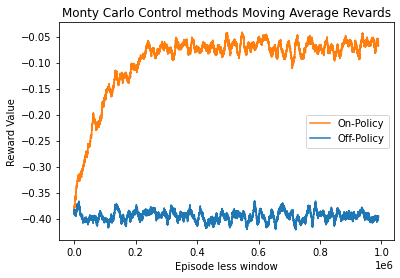

In [ ]:
# setup M/A window size and runs
win_size = 10000
runs = 1000000
# run it
pon, Qon, avrewon = mc_control_on_policy(env, runs, 0.015, win_size)
poff, Qof, avrewof = mccofpcy(env, runs, 0.015, win_size)
plt.plot(avrewon, color = 'tab:orange', label='On-Policy')
plt.plot(avrewof, color = 'tab:blue', label='Off-Policy')
plt.title('Monty Carlo Control methods Moving Average Revards' )
plt.xlabel('Episode less window')
plt.ylabel('Reward Value')
plt.legend()
plt.show()

Plot the policy for both methods (code given in prac)

In [ ]:
def cpof(env,gms,pcy):
    #setup the 
    avpo = []
    
    # run the policy for number of games
    for g in range(gms):
        # set total payout
        tp=0
        # get stating state
        st = env.reset()
        # set to not done
        done = False
        while not done:
            # look up the poilcy for the state and retieve action
            act = pcy[st]
            # play the selected action
            st, po, done, _ = env.step(act)
            # add hand rewards
            tp =+ po
        # append the hand reward to total payout               
        avpo.append(tp)
    # Calc average rewards and formant   
    res = "Ave rewards after {} hands is {}".format(gms, sum(avpo)/gms)
    return res, avpo

In [ ]:
def plotrew(ron,tavon, roff, tavoff, ws):
    #print(r)
    #print(ws)
    #print(t)
    aron = []
    aroff = []
    for ir in range(0, len(ron)-ws):
        #print ('ir',ir)
        if ir > ws : # and i_episode % (winsize/10) == 0:
          aron.append(sum(ron[ir:ir+ws])/ws)
    for io in range(0, len(roff)-ws):
        #print ('ir',ir)
        if io > ws : # and i_episode % (winsize/10) == 0:
          aroff.append(sum(roff[io:io+ws])/ws)
          #print(arw)
          #print("mar", mar)
    plt.plot(aron, color = 'tab:orange', label='On-Policy ' + str(tavon) )
    plt.plot(aroff, color = 'tab:blue', label='Off-Policy ' + str(tavoff) )
    plt.title("Moving Average Rewards with Window Size of " + str(ws) )
    plt.xlabel('Episodes not inlcuding windows')
    plt.ylabel('Reward Value')
    plt.legend()
    plt.show()

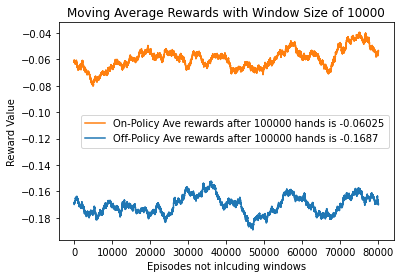

In [ ]:
hnds = 100000
tavon, aponp = cpof (env,hnds, pon)
tavoff, apoffp = cpof (env,hnds,poff)
ws = 10000
plotrew (aponp, tavon, apoffp, tavoff , ws)



On-Policy


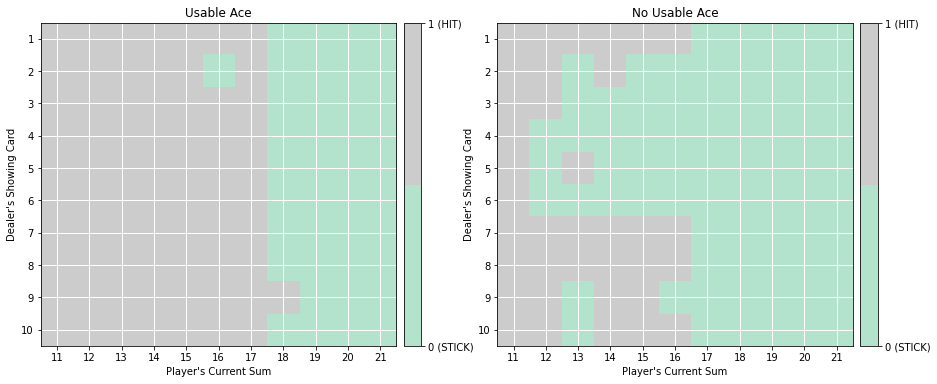

Off-Policy


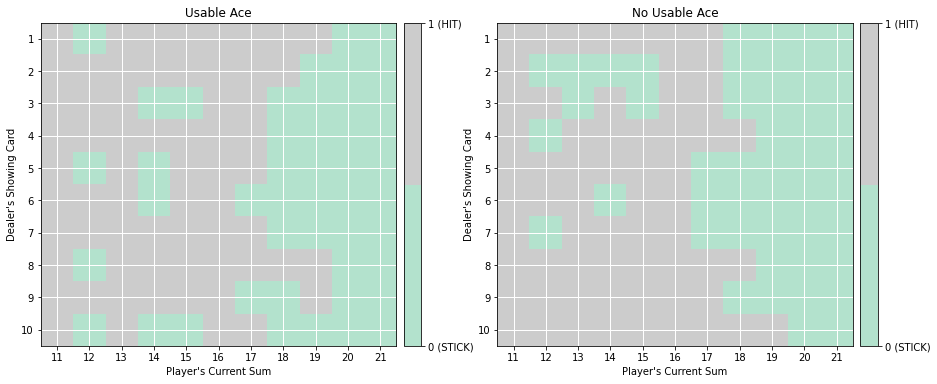

In [ ]:
# given in prac 4

def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

# setup bold srting
def bs(strng):
  bold = "\033[1m" + strng + "\033[0m"
  return bold

# plot the policy
print (bs('On-Policy'))
plot_policy(pon)
print (bs('Off-Policy'))
plot_policy(poff)
